In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

#md = pd.read_csv('/Users/leojo/Developer/alexandrov_sd_proj/Multiscale_HRD_Classifier/prelim_analysis/data/soft_label.tsv', sep='\t', index_col=0)
# import data
brca_df = pd.read_csv('../data/softlabels_per_Subtype.csv', sep=',', index_col=0)
rnaseq_df_init = pd.read_csv('../data/Deconvo2.csv', sep=',', index_col=0)
rnaseq_df_reset = rnaseq_df_init.reset_index()
rnaseq_df = rnaseq_df_reset.rename(columns = {"index": "Case ID"})
rnaseq_df['Case ID'] = rnaseq_df['Case ID'].str.split('-').str[:3].str.join('-')
rnaseq_df['Sample ID'] = rnaseq_df['Case ID'].str.split('-').str[:4].str.join('-')

map = {}
og_rna_df = pd.read_csv('../data/tcga.brca.rnaseq.unstranded.fpkm.counts.matrix.txt')
for i, v in enumerate(og_rna_df.columns):
    if i > 2:
        map[v.split('|')[0]] =v.split('|')[1]


# Drop rows where event.BRCA1 is '1'
brca_df_filtered = brca_df[brca_df['event.BRCA1'] != '1']

# Drop rows where event.BRCA2 is 'Bi-allelic-undetermined'
brca_df_filtered = brca_df_filtered[brca_df_filtered['event.BRCA2'] != 'Bi-allelic-undetermined']
#brca_df_filtered = brca_df_filtered[brca_df_filtered['event.BRCA2'] == '0']

# Drop rows where event.PALB2 is '2'
brca_df_filtered = brca_df_filtered[brca_df_filtered['event.PALB2'] != '2']

# keep common samples

#idenfity the common samples

# Extract sample IDs from each dataframe
rnaseq_samples = set(rnaseq_df['Case ID'])
brca_samples = set(brca_df_filtered.index)

# Find the intersection of all sample IDs
common_samples = rnaseq_samples.intersection(brca_samples)

# Print the number of common samples
print("\nNumber of common samples:", len(common_samples))

# Drop samples that are not common in all three dataframes
rnaseq_df_common = rnaseq_df[rnaseq_df['Case ID'].isin(common_samples)]
rnaseq_df_common.rename(columns=map, inplace=True)
brca_df_common = brca_df_filtered[brca_df_filtered.index.isin(common_samples)]

# Print the shapes of the new dataframes
print("rnaseq_df_common:", rnaseq_df_common.shape)
print("brca_df_common:", brca_df_common.shape)
# Check for duplicates in rnaseq_df_common's Case ID
print("Duplicate Case IDs in rnaseq_df:", rnaseq_df_common['Case ID'].duplicated().sum())

# Drop duplicates in rnaseq_df_common if any
rnaseq_df_common = rnaseq_df_common.drop_duplicates(subset=['Case ID'])

# Verify the shapes after removing duplicates
print("\nAfter removing duplicates:")
print("rnaseq_df_common:", rnaseq_df_common.shape)
print("brca_df_common:", brca_df_common.shape)

# Verify that we have exactly the same samples in both dataframes
rnaseq_samples = set(rnaseq_df_common['Case ID'])
brca_samples = set(brca_df_common.index)
print("\nSamples match:", rnaseq_samples == brca_samples)
print("Number of samples in each:", len(rnaseq_samples), len(brca_samples))

rnaseq_df_common.set_index('Case ID', inplace=True)
rnaseq_df_common.head()

# Sort the samples in both dataframes by index
rnaseq_df_common = rnaseq_df_common.sort_index()
brca_df_common = brca_df_common.sort_index()

# Verify indices match exactly
indices_match = (rnaseq_df_common.index == brca_df_common.index).all()
print("\nIndices match exactly:", indices_match)

print(brca_df_common.shape)
brca_df_common.head()
print(rnaseq_df_common.shape)
rnaseq_df_common.head()
# filter to top 2 percent of differentially expressed genes
deseq_results=pd.read_csv('../data/basic_deseq_HRD_contrast.csv', index_col=0)
#deseq_results = deseq_results_init.loc[['BRCA1', 'BRCA2', 'PALB2', 'RAD51C', 'PARP1', 'PARP2', 'PARP3']]



deseq_results.head()

# Filter columns in rna_seq_df based on deseq_results row indices
deseq_filtered_rna_seq_df = rnaseq_df_common[[col for col in rnaseq_df_common.columns if col in deseq_results.index]]
print(deseq_filtered_rna_seq_df.shape)
deseq_filtered_rna_seq_df.head()
#Filter to top 2% of all protein genes
#drop non-protein coding genes

# Step 1: Filter for protein coding genes (from your original code)
#columns_to_keep = ['Sample ID', 'Sample Type']
columns_to_keep = ['Sample ID']
gene_columns = [col for col in rnaseq_df_common.columns if col not in columns_to_keep]
protein_coding_cols = [col for col in gene_columns if 'protein_coding' in col]
final_columns = columns_to_keep + protein_coding_cols
pcg_rnaseq_df_filtered = rnaseq_df_common[final_columns]


# Step 2: Calculate mean expression for each gene
# First, separate metadata columns from gene expression columns
gene_expression = pcg_rnaseq_df_filtered[protein_coding_cols]
metadata = pcg_rnaseq_df_filtered[columns_to_keep]


# Calculate mean expression for each gene
gene_means = gene_expression.mean(axis=0)

# Calculate number of genes to keep (top 2%)
n_genes_to_keep = 400

# Get the column names (genes) with highest mean expression
top_genes = gene_means.nlargest(n_genes_to_keep).index

# Create final dataframe with metadata and top genes
pcg_400_with_metadata = pd.concat([metadata, pcg_rnaseq_df_filtered[top_genes]], axis=1)

# Create final dataframe with only top genes
pcg_400 = pcg_rnaseq_df_filtered[top_genes]

# Print information about the filtering
print("Original number of protein coding genes:", len(protein_coding_cols))
print("Number of top genes kept (2%):", n_genes_to_keep)
print("\nDataframe shapes:")
print("Original:", rnaseq_df.shape)
print("After protein coding filter:", pcg_rnaseq_df_filtered.shape)
print("Final (with top 2% genes) with metadata:", pcg_400_with_metadata.shape)
print("Final (with top 2% genes):", pcg_400.shape)



# Optional: Show summary statistics of the mean expression values
print("\nMean expression summary for top genes:")
print(gene_means[top_genes].describe())

# Save results to new dataframe
rnaseq_df_top_genes = pcg_400

# Optional: verify that our key columns are still present
print("\nChecking if key columns are present:")
for col in columns_to_keep:
    print(f"{col} present: {col in rnaseq_df_top_genes.columns}")
rnaseq_df_top_genes.head()
#files to use for training/testing

#top 2% of expressed protein coding genes
rnaseq_df_top_genes.head()
print(rnaseq_df_top_genes.shape)

#top 2% of differentially expressed genes
deseq_filtered_rna_seq_df.head()
print(deseq_filtered_rna_seq_df.shape)

#metadata with soft labels
brca_df_common.head()
print(brca_df_common.shape)



Number of common samples: 857
rnaseq_df_common: (857, 9855)
brca_df_common: (857, 40)
Duplicate Case IDs in rnaseq_df: 0

After removing duplicates:
rnaseq_df_common: (857, 9855)
brca_df_common: (857, 40)

Samples match: True
Number of samples in each: 857 857

Indices match exactly: True
(857, 40)
(857, 9854)
(857, 6403)
Original number of protein coding genes: 0
Number of top genes kept (2%): 400

Dataframe shapes:
Original: (933, 9855)
After protein coding filter: (857, 1)
Final (with top 2% genes) with metadata: (857, 1)
Final (with top 2% genes): (857, 0)

Mean expression summary for top genes:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
dtype: float64

Checking if key columns are present:
Sample ID present: False
(857, 0)
(857, 6403)
(857, 40)


/var/folders/vh/rzymgl1d6c79q_4lhgmys8cm0000gn/T/ipykernel_63564/3655963541.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rnaseq_df_common.rename(columns=map, inplace=True)


In [2]:
genes_validation = pd.read_csv('../data/validation/CCLE_RNAseq_genes_counts_20180929.gct', sep="\t", skiprows=2)
# Drop the 'Ensembl IDs' column
genes_validation_transposed = genes_validation.drop(columns=['Name'])

# Set the 'Description' column as the new header (column names)
genes_validation_transposed = genes_validation_transposed.set_index('Description').transpose()

#genes_validation_transposed_sorted = genes_validation_transposed.sort_index(axis = 1)

In [3]:
# drop duplicates
genes_validation_transposed_sorted = genes_validation_transposed.loc[:, ~genes_validation_transposed.columns.duplicated()]

In [4]:
# Step 1: Find common columns
common_columns = set(deseq_filtered_rna_seq_df.columns).intersection(genes_validation_transposed.columns)

# Step 2: Filter each dataframe to keep only common columns
deseq_filtered_rna_seq_df_common = deseq_filtered_rna_seq_df[list(common_columns)]
genes_validation_common = genes_validation_transposed_sorted[list(common_columns)]

# Display the resulting shapes to confirm
print("Shape of filtered deseq_filtered_rna_seq_df:", deseq_filtered_rna_seq_df_common.shape)
print("Shape of filtered genes_validation:", genes_validation_common.shape)


Shape of filtered deseq_filtered_rna_seq_df: (857, 6347)
Shape of filtered genes_validation: (1019, 6347)


In [34]:
breast_filt = genes_validation_common[genes_validation_common.index.str.contains('BREAST')]

In [35]:
breast_filt_idx = breast_filt.set_index(breast_filt.index.str.split('_').str[0])

In [36]:
breast_filt = breast_filt[deseq_filtered_rna_seq_df_common.columns]

In [37]:
sorted(deseq_filtered_rna_seq_df_common.columns)
# sorted(brca_df_common.columns)

['A1BG',
 'A2M',
 'AAAS',
 'AAGAB',
 'AAMDC',
 'AARD',
 'AARS2',
 'AATF',
 'ABAT',
 'ABCA2',
 'ABCA3',
 'ABCA7',
 'ABCB10',
 'ABCB8',
 'ABCC1',
 'ABCC10',
 'ABCC11',
 'ABCC3',
 'ABCD3',
 'ABCD4',
 'ABCE1',
 'ABCF1',
 'ABCF2',
 'ABCF3',
 'ABCG1',
 'ABHD1',
 'ABHD13',
 'ABHD14A',
 'ABHD14B',
 'ABHD17A',
 'ABHD17B',
 'ABHD2',
 'ABI1',
 'ABI2',
 'ABR',
 'ABRACL',
 'ABT1',
 'ABTB1',
 'ACAA1',
 'ACAA2',
 'ACAD10',
 'ACAD8',
 'ACAD9',
 'ACADS',
 'ACADSB',
 'ACADVL',
 'ACAN',
 'ACAP2',
 'ACAT2',
 'ACBD4',
 'ACD',
 'ACIN1',
 'ACO2',
 'ACOT13',
 'ACOT2',
 'ACOT4',
 'ACOT7',
 'ACOT8',
 'ACOX1',
 'ACOX2',
 'ACOX3',
 'ACP1',
 'ACP5',
 'ACP6',
 'ACSF2',
 'ACSL1',
 'ACSL5',
 'ACSS1',
 'ACSS2',
 'ACTB',
 'ACTG1',
 'ACTG2',
 'ACTL10',
 'ACTL6A',
 'ACTN1',
 'ACTN4',
 'ACTR2',
 'ACTR3',
 'ACTR3B',
 'ACTR3C',
 'ACTR5',
 'ACTR6',
 'ACTR8',
 'ACVR1B',
 'ACY1',
 'ACYP1',
 'ACYP2',
 'ADAL',
 'ADAM12',
 'ADAM17',
 'ADAM8',
 'ADAM9',
 'ADAMTS15',
 'ADAMTSL4',
 'ADARB1',
 'ADAT3',
 'ADCY1',
 'ADCY3',
 'ADCY4',
 


Training models on differentially expressed genes:


/Users/johnsmith/miniconda3/envs/HRDclass/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


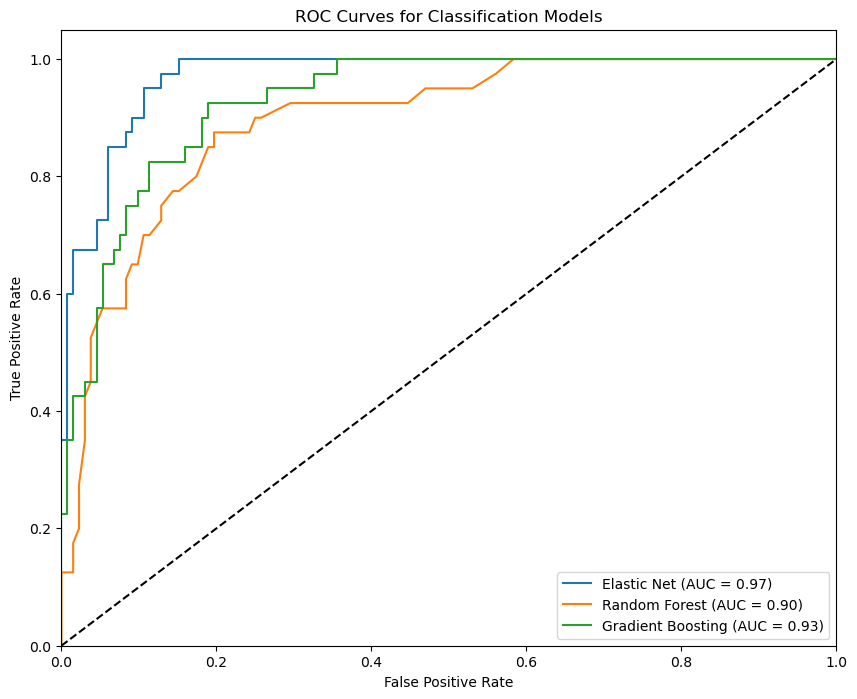


Results for differentially expressed genes:

Elastic Net:
AUC: 0.970

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       132
           1       0.79      0.85      0.82        40

    accuracy                           0.91       172
   macro avg       0.87      0.89      0.88       172
weighted avg       0.92      0.91      0.91       172


Confusion Matrix:
[[123   9]
 [  6  34]]

Random Forest:
AUC: 0.895

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       132
           1       0.81      0.53      0.64        40

    accuracy                           0.86       172
   macro avg       0.84      0.74      0.78       172
weighted avg       0.86      0.86      0.85       172


Confusion Matrix:
[[127   5]
 [ 19  21]]

Gradient Boosting:
AUC: 0.930

Classification Report:
              precision    recall  f1-score   support

       

{'Elastic Net': {'AUC': 0.9704545454545455,
  'Confusion Matrix': array([[123,   9],
         [  6,  34]]),
  'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.95      0.93      0.94       132\n           1       0.79      0.85      0.82        40\n\n    accuracy                           0.91       172\n   macro avg       0.87      0.89      0.88       172\nweighted avg       0.92      0.91      0.91       172\n'},
 'Random Forest': {'AUC': 0.8951704545454545,
  'Confusion Matrix': array([[127,   5],
         [ 19,  21]]),
  'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.87      0.96      0.91       132\n           1       0.81      0.53      0.64        40\n\n    accuracy                           0.86       172\n   macro avg       0.84      0.74      0.78       172\nweighted avg       0.86      0.86      0.85       172\n'},
 'Gradient Boosting': {'AUC': 0.9301136363636364,


In [30]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


baby  = None
# Data Preprocessing Function
def preprocess_data(X, y, task='classification'):
    # Encode categorical labels
    if task == 'classification':
        le = LabelEncoder()
        y = le.fit_transform(y)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

# Model Training & Evaluation Function for Classification
def train_evaluate_classification_models(X_train, X_test, y_train, y_test):
    global baby
    models = {
        'Elastic Net': LogisticRegression(penalty='elasticnet', solver='saga', 
                                        l1_ratio=0.5, max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42)
    }
    
    results = {}
    plt.figure(figsize=(10, 8))
    
    for name, model in models.items():
        # Train model
        model.fit(X_train, y_train)
        
        # Get predictions
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
        
        # Store results
        results[name] = {
            'AUC': roc_auc,
            'Confusion Matrix': confusion_matrix(y_test, y_pred),
            'Classification Report': classification_report(y_test, y_pred)
        }
        if name == 'Elastic Net':
            baby = model
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Classification Models')
    plt.legend(loc="lower right")
    plt.show()
    
    return results

# Main execution
def main():
    print("\nTraining models on differentially expressed genes:")
    
    X_train_de, X_test_de, y_train_de, y_test_de = preprocess_data(
        deseq_filtered_rna_seq_df_common, brca_df_common['HRD_status_base'], task='classification'
    )
    
    results_de = train_evaluate_classification_models(
        X_train_de, X_test_de, y_train_de, y_test_de
    )
    
    print("\nResults for differentially expressed genes:")
    for model_name, metrics in results_de.items():
        print(f"\n{model_name}:")
        print(f"AUC: {metrics['AUC']:.3f}")
        print("\nClassification Report:")
        print(metrics['Classification Report'])
        print("\nConfusion Matrix:")
        print(metrics['Confusion Matrix'])
    return results_de

# # For regression task on Confidence values
# def train_evaluate_regression_models(X_train, X_test, y_train, y_test):
#     models = {
#         'Elastic Net': ElasticNet(random_state=42),
#         'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
#         'Gradient Boosting': GradientBoostingRegressor(random_state=42)
#     }
    
#     results = {}
    
#     for name, model in models.items():
#         # Train model
#         model.fit(X_train, y_train)
        
#         # Get predictions
#         y_pred = model.predict(X_test)
        
#         # Calculate metrics
#         mse = mean_squared_error(y_test, y_pred)
#         r2 = r2_score(y_test, y_pred)
        
#         # Store results
#         results[name] = {
#             'MSE': mse,
#             'R2': r2
#         }
        
#         # Plot actual vs predicted
#         plt.figure(figsize=(8, 6))
#         plt.scatter(y_test, y_pred, alpha=0.5)
#         plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
#         plt.xlabel('Actual Confidence')
#         plt.ylabel('Predicted Confidence')
#         plt.title(f'{name} - Actual vs Predicted')
#         plt.show()
    
#     return results
googog = main()
googog


In [31]:
baby

LogisticRegression(l1_ratio=0.5, max_iter=1000, penalty='elasticnet',
                   solver='saga')

In [39]:
predictions = baby.predict(breast_filt)
# Display or save the predictions
print(predictions)

# Optionally, add predictions as a new column to the DataFrame
breast_filt['predictions'] = predictions

[0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


/Users/johnsmith/miniconda3/envs/HRDclass/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [43]:
breast_filt.index = breast_filt.index.str.split('_').str[0]

In [44]:
breast_filt

Description,CCT3,PPP2R5B,NUDT15,NDST1,S100A2,PRR14L,C12orf76,TNKS,SFXN5,ZC3H10,...,CAMSAP2,GTPBP2,E2F3,EHBP1,PPARA,CAB39L,RBX1,ACTN4,ANXA9,predictions
AU565,96516.0,1571.0,7307.0,62172.0,188.0,9037.0,565.0,4930.0,3427.0,674.0,...,16657.0,6770.0,6790.0,7025.0,4490.0,2347.0,1990.0,71282.0,1353.0,0
BT20,92469.0,1079.0,10445.0,17874.0,406.0,12087.0,830.0,4475.0,2275.0,260.0,...,12042.0,14604.0,9283.0,9541.0,4046.0,2508.0,2951.0,248570.0,6141.0,0
BT474,103352.0,2272.0,3354.0,21496.0,100.0,8015.0,1210.0,3442.0,2538.0,575.0,...,3915.0,6009.0,5549.0,2488.0,104.0,2165.0,1874.0,66732.0,1006.0,0
BT483,77584.0,2918.0,2445.0,45443.0,170.0,6984.0,2256.0,5753.0,8530.0,936.0,...,14180.0,10732.0,6233.0,3194.0,1276.0,5756.0,1173.0,96574.0,20316.0,0
BT549,88727.0,3885.0,7434.0,62100.0,2505.0,8130.0,762.0,17498.0,3292.0,498.0,...,19646.0,12217.0,12546.0,8899.0,887.0,759.0,3175.0,154272.0,61.0,0
CAL120,38605.0,3426.0,2352.0,13482.0,13035.0,5719.0,1252.0,6999.0,565.0,218.0,...,10672.0,7276.0,6915.0,11577.0,2407.0,749.0,1747.0,111214.0,250.0,0
CAL148,126900.0,3614.0,1470.0,62742.0,117.0,12462.0,1694.0,7504.0,6749.0,1504.0,...,20306.0,14736.0,12611.0,6345.0,5411.0,1691.0,2176.0,92398.0,677.0,0
CAL51,36731.0,1291.0,9247.0,15450.0,279.0,8256.0,1254.0,11730.0,3483.0,643.0,...,10138.0,9542.0,8588.0,6861.0,2900.0,1414.0,2086.0,82256.0,218.0,0
CAL851,67387.0,1441.0,5126.0,9507.0,5779.0,4151.0,480.0,3319.0,2844.0,289.0,...,4859.0,14096.0,6803.0,7624.0,1586.0,1516.0,3080.0,149877.0,2185.0,1
CAMA1,113992.0,1952.0,6333.0,56183.0,196.0,18877.0,2111.0,5900.0,6796.0,659.0,...,21632.0,22684.0,15583.0,6328.0,1245.0,7159.0,4176.0,81110.0,8863.0,0


In [46]:
drug_resp = pd.read_csv('../data/validation/BRCA_IC_Sat Jan 11 20_40_55 2025.csv')
parps = ['Olaparib', 'Talazoparib', 'Niraparib', 'Rucaparib', 'Veliparib']
parpi_resp = drug_resp[drug_resp['Drug Name'].isin(parps)]
parpi_resp_filt = parpi_resp[['Drug Name', 'Cell Line Name', 'IC50']]
parpi_resp_filt['log10IC50'] = np.log10(parpi_resp_filt['IC50'])
test = parpi_resp_filt[parpi_resp_filt['Drug Name'] == 'Olaparib']

/Users/johnsmith/miniconda3/envs/HRDclass/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/vh/rzymgl1d6c79q_4lhgmys8cm0000gn/T/ipykernel_63564/1877962698.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parpi_resp_filt['log10IC50'] = np.log10(parpi_resp_filt['IC50'])


In [57]:
test['Cell Line Name'] = test['Cell Line Name'].str.replace('-', '', regex=False)

/var/folders/vh/rzymgl1d6c79q_4lhgmys8cm0000gn/T/ipykernel_63564/2008896216.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Cell Line Name'] = test['Cell Line Name'].str.replace('-', '', regex=False)


In [77]:
import plotly_express as px

In [90]:
from scipy.stats import ttest_ind
import plotly_express as px
stats = {}
for drug in parpi_resp['Drug Name'].unique():
    #print(drug)
    d = parpi_resp_filt[parpi_resp_filt['Drug Name'] == drug]
    merged = d.merge(breast_filt.reset_index(), left_on='Cell Line Name', right_on='index')

    merged = merged.sort_values(by='Cell Line Name')

    group_0 = merged.loc[merged['predictions'] == 0, 'log10IC50']
    group_1 = merged.loc[merged['predictions'] == 1, 'log10IC50']


    t_stat, p_value = ttest_ind(group_0, group_1, equal_var = False)
    stats[drug] = p_value    
stats

{'Olaparib': 0.5954334358040023,
 'Veliparib': 0.7527953274024755,
 'Rucaparib': 0.42509753860488925,
 'Niraparib': 0.002644401594187822,
 'Talazoparib': 0.8746910239846752}

In [92]:
merged = parpi_resp_filt.merge(breast_filt.reset_index(), left_on='Cell Line Name', right_on='index')
px.box(merged, x = 'Drug Name', y = 'log10IC50', color = 'predictions')